In [288]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

In [236]:
file_dir = Path('.\CalData\Accel Measurements')

In [237]:
file_name = 'torqueCal_20460001_horiz_4.txt'
fname = file_dir/file_name
fname

WindowsPath('CalData/Accel Measurements/torqueCal_20460001_horiz_4.txt')

In [238]:
ftm_freq = 60e6
N_enc = int(400)

f = open(fname, "r")
sn = f.readline()
if sn[0] == '#':
    shaftIndex = f.readline()
    rotorOffset = f.readline()
    sn = sn.strip('# sn = ').strip()
    print(f'Chopper Head serial number: {sn}')
    rotorOffset = int(rotorOffset.strip('# rotor offset = ').strip())

f.close()

print(f'rotor offset = {rotorOffset}')

rowsToSkip = 5
#revsToImport = 12
revsToImport = 7
rowsToImport = N_enc*revsToImport
N_revs = int(rowsToImport/N_enc)
print(f'Importing {rowsToImport} rows ({N_revs} revs worth of data)')

# Assumes raw data contains 3 columns: raw count, ftm input captures of edges, (ignore column 3)
df = pd.read_csv(fname, sep=',', skiprows=rowsToSkip, nrows = rowsToImport, 
             index_col=False, comment='#', names=['count', 'input cap', 'phase'])        

count = df['count'].to_numpy()
missedOrExtraCounts = np.where(np.mod(np.diff(count), 400) != 1)[0]
if missedOrExtraCounts.size > 0:
    print(f'Found missing or extra counts at: {missedOrExtraCounts}')
    print(f'Data set reduced to {missedOrExtraCounts[0]/N_enc} revs')
    df = df.loc[0:missedOrExtraCounts[0]]
else:
    print("No missing or extra counts")    

# Convert raw encoder counts to unwrapped encoder count 
count = df['count'].to_numpy()

Chopper Head serial number: 20460001
rotor offset = 32
Importing 2800 rows (7 revs worth of data)
No missing or extra counts


In [239]:
phase_revs = df['phase'].to_numpy()

In [240]:
uwPhase_revs = np.unwrap(phase_revs*2*np.pi)/(2*np.pi)
uwPhase_revs -= uwPhase_revs[0]
uwPhase_revs

array([0.00000000e+00, 2.47919559e-03, 5.00774384e-03, ...,
       6.99248022e+00, 6.99500734e+00, 6.99762881e+00])

In [241]:
rotorAngle = np.array((count + rotorOffset)%N_enc, dtype='int')
uwRotorAngle_revs = np.unwrap(rotorAngle/400*2*np.pi)/(2*np.pi   )
uwRotorAngle_revs -= uwRotorAngle_revs[0]

# Convert ftm input capture counts to unwrapped time in seconds
captures = df['input cap'].to_numpy()            
captureDiffs = np.mod(np.diff(captures, prepend=0), 65536)
t_s = (np.cumsum(captureDiffs) - captureDiffs[0])/ftm_freq  

In [242]:
uwRotorAngle_revs

array([0.0000e+00, 2.5000e-03, 5.0000e-03, ..., 6.9925e+00, 6.9950e+00,
       6.9975e+00])

<IPython.core.display.Javascript object>


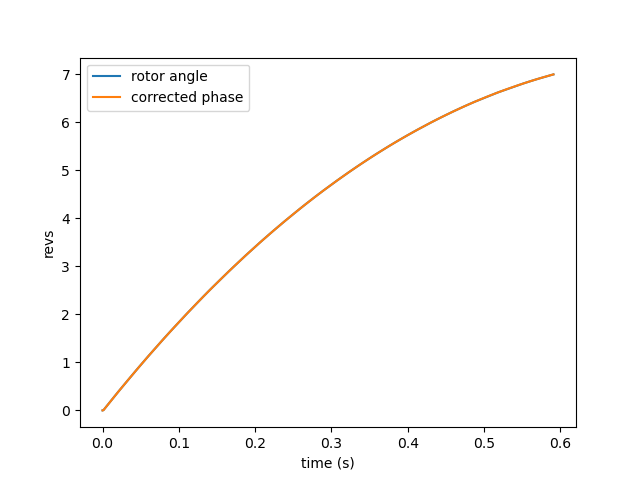

In [243]:
%matplotlib notebook
plt.plot(t_s, uwRotorAngle_revs, label='rotor angle')
plt.plot(t_s, uwPhase_revs, label='corrected phase')
plt.xlabel('time (s)')
plt.ylabel('revs')
plt.legend()

<IPython.core.display.Javascript object>


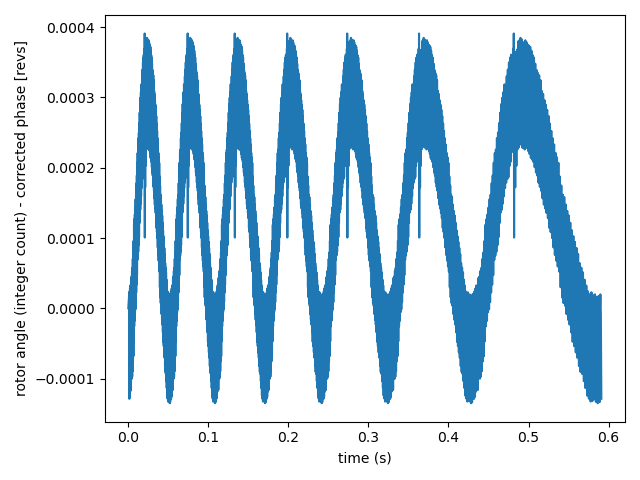

In [244]:
plt.plot(t_s, uwRotorAngle_revs - uwPhase_revs)
plt.xlabel('time (s)')
plt.ylabel('rotor angle (integer count) - corrected phase [revs]')
plt.tight_layout()

In [245]:
stepSize = 16

In [246]:
speed_revs_s = []
for i in range(stepSize):
    # Use calibrated phase:
    speed_revs_s.append(np.gradient(uwPhase_revs[i::stepSize], t_s[i::stepSize]))
    # Or use raw rotor angle:
    #speed_revs_s.append(np.gradient(uwRotorAngle_revs[numDataPointsToDrop+i::stepSize], t_s[numDataPointsToDrop+i::stepSize]))

<IPython.core.display.Javascript object>


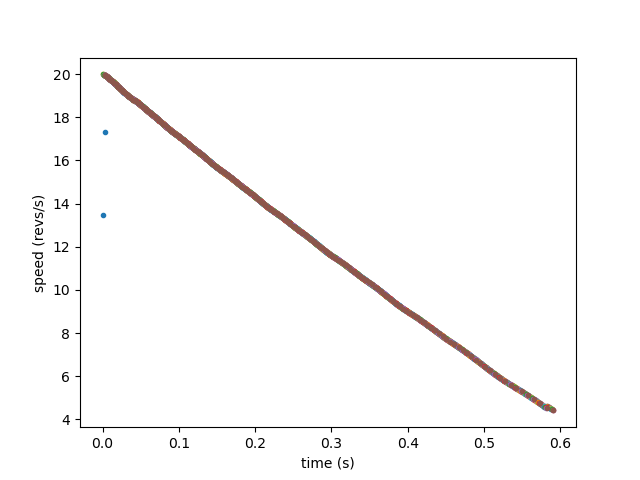

Text(0, 0.5, 'speed (revs/s)')

In [247]:
for i in range(stepSize):
    plt.plot(t_s[i::stepSize], speed_revs_s[i], '.')
    
plt.xlabel('time (s)')
plt.ylabel('speed (revs/s)')

In [248]:
accel_revs_s2 = []
for i in range(stepSize):
    accel_revs_s2.append(np.gradient(speed_revs_s[i], t_s[i::stepSize]))

<IPython.core.display.Javascript object>


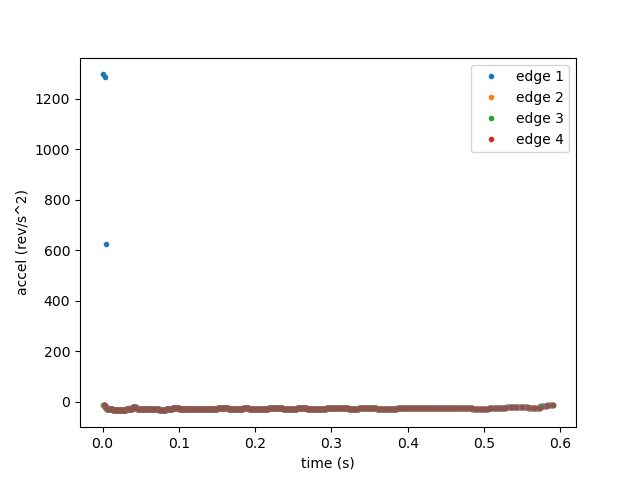

In [249]:
%matplotlib notebook
for i in range(stepSize):
    plt.plot(t_s[i::stepSize], accel_revs_s2[i], '.')
    
plt.xlabel('time (s)')
plt.ylabel('accel (rev/s^2)')
plt.legend(('edge 1', 'edge 2', 'edge 3', 'edge 4'))    

In [250]:
# Reassemble acceleration arrays into a single array
a = np.zeros(len(accel_revs_s2)*len(accel_revs_s2[0]))
for i in range(stepSize):
    a[i::stepSize] = accel_revs_s2[i]

<IPython.core.display.Javascript object>


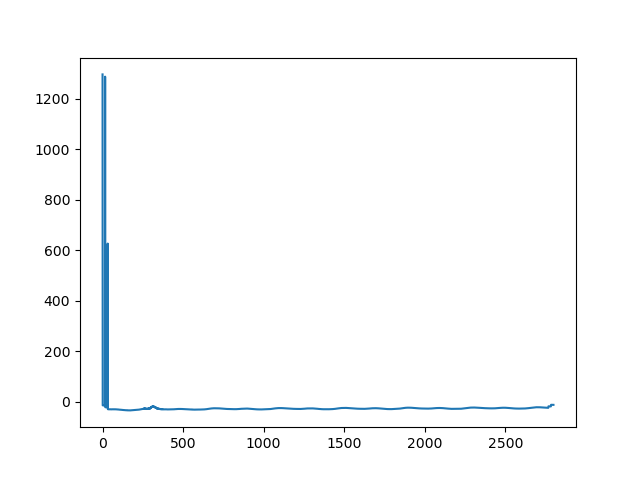

In [251]:
plt.plot(a)

In [252]:
# Empirically, determined that the first and last few data points should be discarded

# Select an integer number of revolutions (N*400)
a = a[400:2401]
phase = uwPhase_revs[400:2401] - uwPhase_revs[400]
rotAngle = rotorAngle[400:2401]

In [253]:
phase

array([0.00000000e+00, 2.47919559e-03, 5.00774384e-03, ...,
       4.99500734e+00, 4.99762881e+00, 5.00000000e+00])

<IPython.core.display.Javascript object>


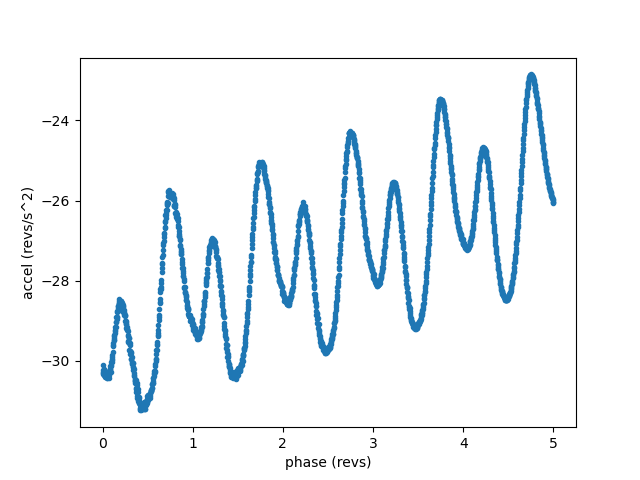

Text(0, 0.5, 'accel (revs/s^2)')

In [254]:
plt.plot(phase, a, '.')
plt.xlabel('phase (revs)')
plt.ylabel('accel (revs/s^2)')

In [255]:
# Accel data "a" has one extra data point in order to be able to force periodic boundary conditions
len(a)/400

5.0025

In [256]:
# Subtract linear trend based on first and last data points, forcing periodic boundary conditions

# Make sure first and last data points were collected at some rotorAngle
print(f'first data point at rotor angle = {rotAngle[0]}')
print(f'last data point at rotor angle = {rotAngle[-1]}')

linearTrend = np.linspace(a[0], a[-1], len(a))

first data point at rotor angle = 311
last data point at rotor angle = 311


<IPython.core.display.Javascript object>


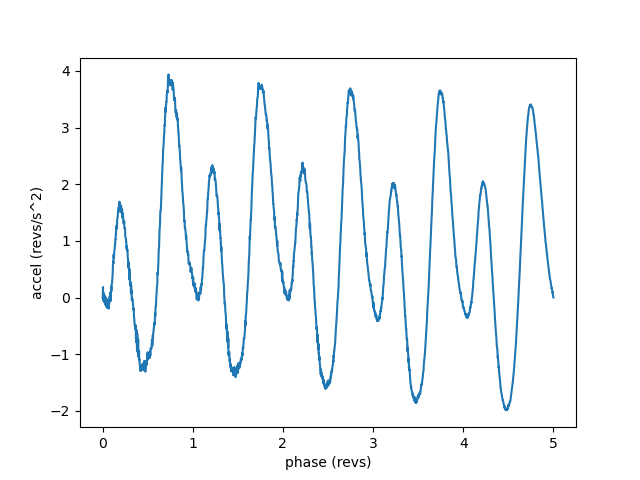

0.0
0.0


In [257]:
a_detrend = a - linearTrend
plt.plot(phase, a_detrend)
plt.xlabel('phase (revs)')
plt.ylabel('accel (revs/s^2)')
print(a_detrend[0])
print(a_detrend[-1])

In [258]:
# Need to generate evenly spaced data in order to compute FFT
a_spline = interp1d(phase, a_detrend, kind='cubic')

In [259]:
phase_evenlySpaced = np.linspace(min(phase), max(phase), len(a_detrend))
phase_evenlySpaced

array([0.0000e+00, 2.5000e-03, 5.0000e-03, ..., 4.9950e+00, 4.9975e+00,
       5.0000e+00])

<IPython.core.display.Javascript object>


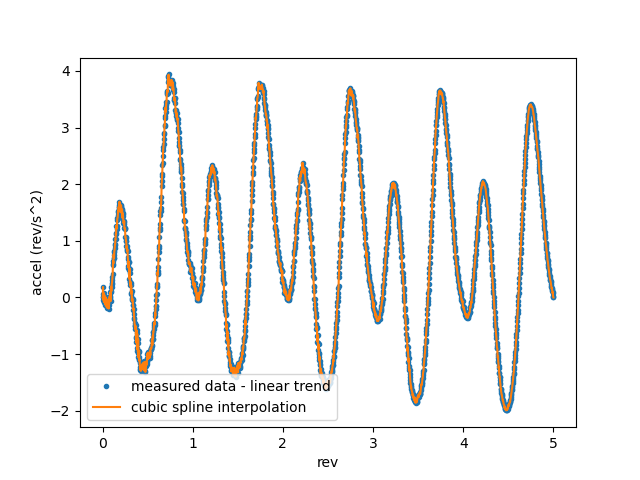

In [260]:
plt.plot(phase, a_detrend, '.', label='measured data - linear trend')
plt.plot(phase_evenlySpaced, a_spline(phase_evenlySpaced), label='cubic spline interpolation')
plt.ylabel('accel (rev/s^2)')
plt.xlabel('rev')
plt.legend()

In [67]:
np.savetxt('accel.txt', np.transpose([allPhases, a_spline(allPhases)]), header = "phase (rev), accel (rev/s^2)", newline='\n', delimiter=',')

In [261]:
# Drop the last data point and do the FFT
len(a_spline(phase_evenlySpaced)[:-1])

2000

In [262]:
a_fft = np.fft.fft(a_spline(phase_evenlySpaced)[:-1])
rotFreq = np.fft.fftfreq(len(a_spline(phase_evenlySpaced)[:-1]), d=1/400)

In [263]:
a_fft

array([1613.61876028  +0.j        ,  -78.37132668-204.96110887j,
        -53.8464104  -17.87215178j, ...,  -55.24610134 +35.46153896j,
        -53.8464104  +17.87215178j,  -78.37132668+204.96110887j])

In [264]:
rotFreq

array([ 0. ,  0.2,  0.4, ..., -0.6, -0.4, -0.2])

<IPython.core.display.Javascript object>


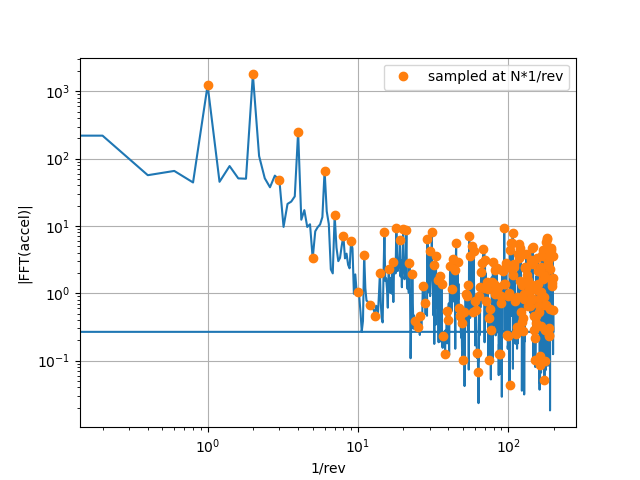

In [265]:
#plt.plot(rotFreq, a_fft.real, '.')
#plt.plot(rotFreq, a_fft.imag, '.')
plt.plot(rotFreq, np.abs(a_fft))
plt.plot(rotFreq[(rotFreq%1 == 0)], np.abs(a_fft)[(rotFreq%1 == 0)], 'o', label='sampled at N*1/rev')
plt.yscale('log')
plt.xscale('log')
plt.grid(axis='both')
plt.xlabel('1/rev')
plt.ylabel('|FFT(accel)|')
plt.legend()

In [266]:
# Try zero'ing everything but the integer multiples of 1/rev
a_fft_filtered = ((rotFreq%1 == 0).astype(int)*a_fft)
a_fft_filtered[0:25]

array([ 1613.61876028  +0.j        ,     0.          -0.j        ,
           0.          -0.j        ,     0.          -0.j        ,
          -0.          +0.j        ,   842.89848743+899.01109026j,
           0.          +0.j        ,     0.          +0.j        ,
           0.          +0.j        ,     0.          +0.j        ,
       -1782.38810711 -50.99810731j,     0.          +0.j        ,
           0.          +0.j        ,     0.          +0.j        ,
           0.          -0.j        ,   -47.25024344 -10.54870094j,
           0.          -0.j        ,     0.          -0.j        ,
          -0.          +0.j        ,    -0.          +0.j        ,
         203.23088266+146.24201263j,    -0.          +0.j        ,
          -0.          +0.j        ,    -0.          +0.j        ,
           0.          +0.j        ])

In [267]:
a_ifft = np.fft.ifft(a_fft_filtered).real

In [269]:
len(rotAngle)

2001

<IPython.core.display.Javascript object>


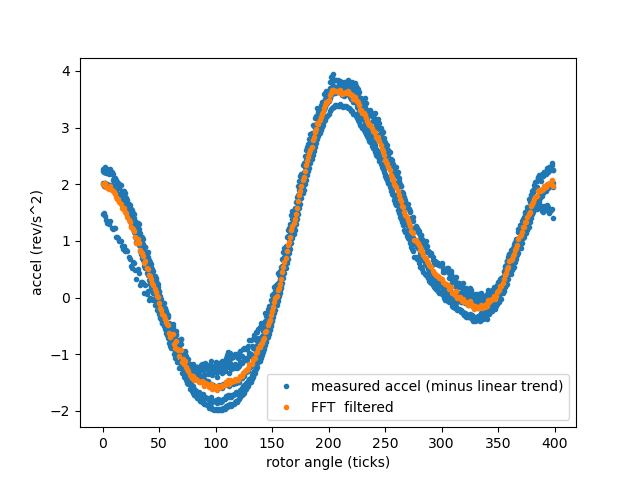

In [274]:
# To make sure phase information is preserved across the FFT and iFFT, plot the original acceleration vs rotor angle too:
plt.plot(rotAngle, a_detrend, '.', label='measured accel (minus linear trend)')

plt.plot(rotAngle[0:400], a_ifft[0:400], '.', label='FFT filtered')

plt.xlabel('rotor angle (ticks)')
plt.ylabel('accel (rev/s^2)')
plt.legend()

<IPython.core.display.Javascript object>


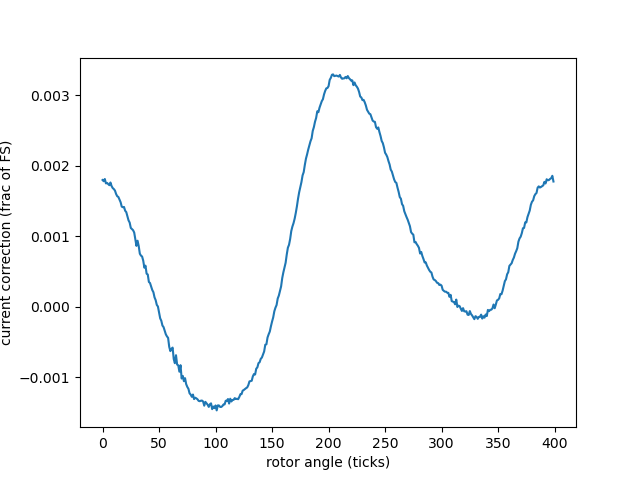

Text(0, 0.5, 'current correction (frac of FS)')

In [286]:
# Convert accleration to torque
J = 1.31e-6 #kg*m^2, from impulse tests with hub only
# Need acceleration in rad/s^2
# And Re-order the acceleration data so that element 0 corresponds to rotor angle 0
alpha = a_ifft[np.argsort(rotAngle[0:N_enc])]*2*np.pi
torque = J*alpha
k_T = 5.55e-3 #N*m/A, from Nuelectronics motor spec sheet
current_corr_A = torque/k_T
current_corr_frac = current_corr_A/1.65

plt.plot(current_corr_frac)
plt.xlabel('rotor angle (ticks)')
plt.ylabel('current correction (frac of FS)')

In [289]:
# Save the data as a cal .csv file:
np.savetxt(os.path.join('.\CalData', f'currCorr_{sn}.csv'), current_corr_frac, newline='\n', fmt='%.6e', delimiter=',')

In [224]:
phase_evenlySpaced

array([0.0000e+00, 2.5000e-03, 5.0000e-03, ..., 4.9950e+00, 4.9975e+00,
       5.0000e+00])

In [226]:
a_spline_filtered = interp1d(phase_evenlySpaced[:-1], a_ifft, kind='cubic')

<IPython.core.display.Javascript object>


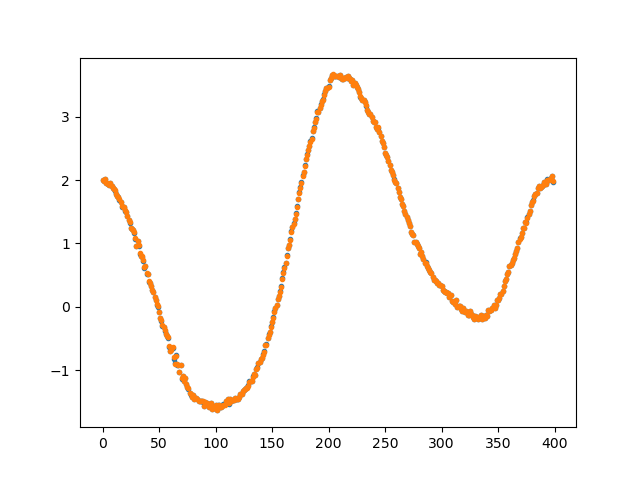

In [231]:
plt.plot(rotAngle[0:400], a_ifft[0:400], '.')
plt.plot(rotAngle[0:400], a_spline_filtered(phase[0:400]), '.')

<IPython.core.display.Javascript object>


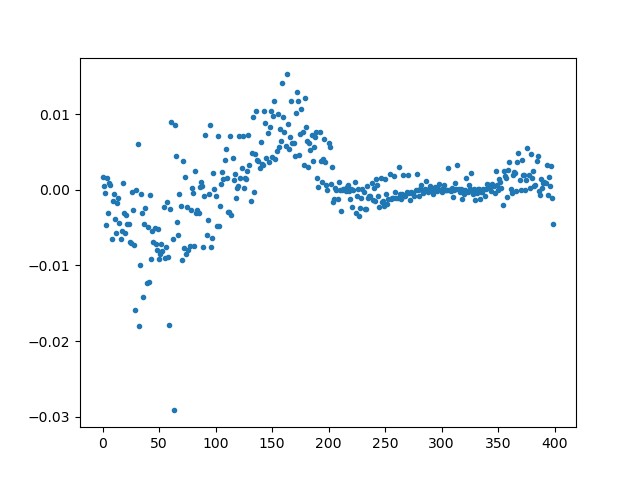

In [234]:
plt.plot(rotAngle[0:400], a_ifft[0:400] - a_spline_filtered(phase[0:400]), '.')